<a href="https://colab.research.google.com/github/STASYA00/IAAC2024_tutorials/blob/main/quickstarts/03_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> - Stasja's notebook

In [1]:
!pip install osmnx geopy scikit-learn ortools ipykernel plotly nbformat

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.8/302.8 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 1.4.0
    Uninstalling absl-py-1.4.0:
      Successfully uninstalled absl-py-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-ai-generativelanguage 0.6.2 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!

In [4]:
!pip install --upgrade nbformat

* [Ortools package](https://developers.google.com/optimization)
* [What is optimization](https://en.wikipedia.org/wiki/Mathematical_optimization)
* [Video on what optimization is](https://youtu.be/AM6BY4btj-M?t=170&si=FUAW-bzml27y61zq) - only 2.50 - 6.00

## 🕍Optimizing house placement

In [2]:
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style()

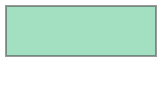

In [3]:
width = 150
depth = 50
x1 = 0
y1 = 0
coords = [(x1, y1), (x1 + width, y1), (x1+width, y1+depth), (x1, y1+depth), (x1, y1)]
house = Polygon(coords)
house

Site geometry

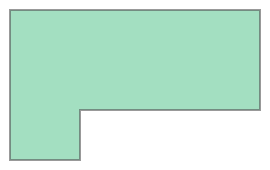

In [5]:
coords = [(0, 0), (70, 0), (70, 50), (250, 50), (250, 150), (0, 150), (0,0)]
site = Polygon(coords)
site

### Optimizing house position

We will be using [CP-SAT](https://developers.google.com/optimization/cp/cp_solver) solver made available to general public by Google.

In [6]:
from ortools.sat.python import cp_model
model = cp_model.CpModel()

Let's place our house onto the site. The constraints would be that:
* all house coordinates are within the site polygon

In [7]:
site.bounds

(0.0, 0.0, 250.0, 150.0)

In [8]:
# Int var says that we create an integer variable that can have any value in a certain range.
# This range is given when we define the variable: here it is 0 and the maximum coordinate of our site (250):
x1 = model.NewIntVar(0, int(max(site.bounds)), 'x1')  # last argument is the name of the variable in the model
x1

x1(0..250)

In [37]:
# The rest of the house coordinates
x2 = model.NewIntVar(0, int(max(site.bounds)), 'x2')

y1 = model.NewIntVar(0, int(max(site.bounds)), 'y1')

y2 = model.NewIntVar(0, int(max(site.bounds)), 'y2')
y2

y2(0..250)

Now let's add the relationship between the coordinates and tell our model that x2 - x1 = width

In [10]:
model.Add(x2-x1==width)
model.Add(y2-y1==depth)

# Note that our house does not rotate at the moment. We are only placing it vertically.

In [11]:
model.Add(x1 < int(site.bounds[2]))
model.Add(y1 < int(site.bounds[3]))
model.Add(x2 < int(site.bounds[2]))
model.Add(y2 < int(site.bounds[3]))

In [12]:
model.Minimize(y2)

In [13]:
solver = cp_model.CpSolver()
status = solver.Solve(model)
status

4

In [14]:
print("x1:", solver.Value(x1))
print("x2:", solver.Value(x2))
print("y1:", solver.Value(y1))
print("y2:", solver.Value(y2))

x1: 0
x2: 150
y1: 0
y2: 50


In [15]:
house_location = Polygon([
    (solver.Value(x1), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y1))])

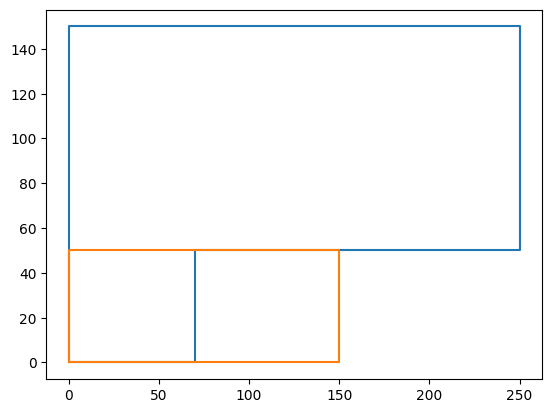

In [16]:
plt.plot(*site.exterior.xy)
plt.plot(*house_location.exterior.xy)

In [17]:
def plot_result(slvr):
    print("x1:", slvr.Value(x1))
    print("x2:", slvr.Value(x2))
    print("y1:", slvr.Value(y1))
    print("y2:", slvr.Value(y2))

    house_location = Polygon([
    (solver.Value(x1), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y1)),
    (solver.Value(x2), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y2)),
    (solver.Value(x1), solver.Value(y1))])

    plt.plot(*site.exterior.xy)
    plt.plot(*house_location.exterior.xy)


Let's adjust our constraints:

In [18]:
model = cp_model.CpModel()
x1 = model.NewIntVar(0, int(max(site.bounds)), 'x1')
x2 = model.NewIntVar(0, int(max(site.bounds)), 'x2')
y1 = model.NewIntVar(0, int(max(site.bounds)), 'y1')
y2 = model.NewIntVar(0, int(max(site.bounds)), 'y2')

model.Add(x2-x1==width)
model.Add(y2-y1==depth)

model.Add(x1 < int(site.bounds[2]))
model.Add(y1 < int(site.bounds[3]))
model.Add(x2 < int(site.bounds[2]))
model.Add(y2 < int(site.bounds[3]))

In [19]:
x1_outside = model.NewBoolVar("x1_outside")  # true if x1 > 70 -> in the question zone
x2_outside = model.NewBoolVar("x2_outside")  # true if x2 > 70 -> in the question zone

In [20]:
model.Add(x1>=70).OnlyEnforceIf(x1_outside)
model.Add(x1<70).OnlyEnforceIf(x1_outside.Not())
model.Add(x2>=70).OnlyEnforceIf(x2_outside)
model.Add(x2<70).OnlyEnforceIf(x2_outside.Not())

In [21]:
model.Add(y1>=50).OnlyEnforceIf(x1_outside)  # if x coordinate is in the "outside zone" y coordinate can only be from 50 to 150
model.Add(y1>=50).OnlyEnforceIf(x2_outside)
model.Add(y2>=50).OnlyEnforceIf(x1_outside)
model.Add(y2>=50).OnlyEnforceIf(x2_outside)

In [22]:
model.Minimize(y2)
solver = cp_model.CpSolver()
status = solver.Solve(model)
status

4

In [23]:
solver.status_name()

'OPTIMAL'

x1: 69
x2: 219
y1: 50
y2: 100


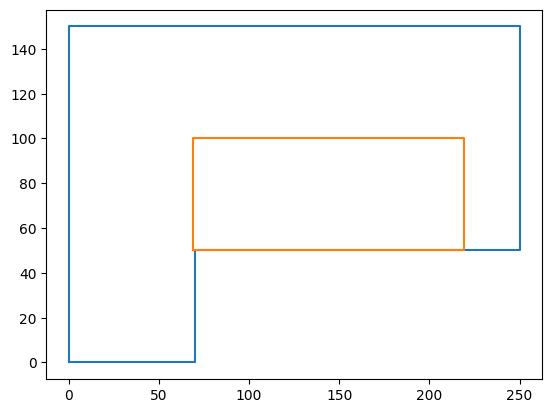

In [24]:
plot_result(solver)

### 🧩 Task I - multiple houses

We learnt how to place a single house on a given site. Let's say we have multiple houses and our goal is to fit as many as possible on a site.

Assume that there are no regulations on distance between the houses.

__Hint:__
* take a look at [2d bin packing](https://yetanothermathprogrammingconsultant.blogspot.com/2021/02/2d-bin-packing-with-google-or-tools-cp.html), feel free to adjust the code
* use [interval var](https://developers.google.com/optimization/reference/python/sat/python/cp_model#newintervalvar)
* use [AddNoOverlap2D](https://developers.google.com/optimization/reference/python/sat/python/cp_model#addnooverlap2d)

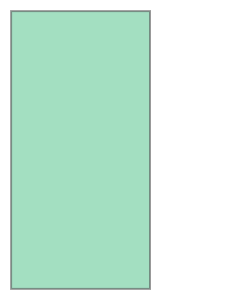

In [118]:
# site_coords = [(0, 0), (70, 0), (70, 50), (250, 50), (250, 150), (0, 150), (0,0)]
site_coords = [(0,0), (200, 0), (200, 400), (0, 400), (0,0)]  # simplified version
site_simplified = Polygon(site_coords)
site_simplified

In [119]:
site_simplified.bounds

(0.0, 0.0, 200.0, 400.0)

In [26]:
# houses are presented as width and height
houses = [
    [20, 40],
    [25, 40],
    [70, 100],
    [75, 30],
    [30, 30],
    [30, 30],
    [12, 25],
    [12, 20],
    [40, 20],
    [40, 30],
    [70, 30],
    [12, 25],
    [12, 20],
    [40, 20],
    [40, 30],
    [70, 30],
]

In [38]:
len(houses)

16

To get you started, we initiate the model and add a variable for each house that shows whether it is placed or not:

In [120]:
model = cp_model.CpModel()
placed_vars = []

for house in range(len(houses)):
    placed_vars.append(model.NewBoolVar("placed_{}".format(house)))

# take a look at it:
placed_vars

[placed_0(0..1),
 placed_1(0..1),
 placed_2(0..1),
 placed_3(0..1),
 placed_4(0..1),
 placed_5(0..1),
 placed_6(0..1),
 placed_7(0..1),
 placed_8(0..1),
 placed_9(0..1),
 placed_10(0..1),
 placed_11(0..1),
 placed_12(0..1),
 placed_13(0..1),
 placed_14(0..1),
 placed_15(0..1)]

Building variables for one house (let's take number 1):

![Variables explanation](https://github.com/STASYA00/IAAC2024_tutorials/blob/main/.assets/optimization/1.jpg?raw=1)

In [121]:
MAX_SITE_WIDTH = max([s[0] for s in site_coords])
MAX_SITE_HEIGHT = max([s[1] for s in site_coords])

x1_coords =[]
x2_coords=[]
y1_coords=[]
y2_coords=[]

for house_number in range(len(houses)):

    x1_coords.append (model.NewIntVar(0,  MAX_SITE_WIDTH, 'x1_{}'.format(house_number)))
    x2_coords.append (model.NewIntVar(0,  MAX_SITE_WIDTH, 'x2_{}'.format(house_number)))
    y1_coords.append (model.NewIntVar(0,  MAX_SITE_HEIGHT, 'y1_{}'.format(house_number)))
    y2_coords.append (model.NewIntVar(0,  MAX_SITE_HEIGHT, 'y2_{}'.format(house_number)))

In [122]:
# interval variables
# Arguments: start, size, end, whether it is placed, variable name
# https://developers.google.com/optimization/reference/python/sat/python/cp_model#newoptionalintervalvar

house_widths = []
house_depths = []

for house_number in range(len(houses)):
    house_widths.append (model.NewOptionalIntervalVar(x1_coords[house_number], houses[house_number][0], x2_coords[house_number],
                                              placed_vars[house_number],
                                              'width_interval_{}'.format(house_number)))

    house_depths.append (model.NewOptionalIntervalVar(y1_coords[house_number], houses[house_number][1], y2_coords[house_number],
                                              placed_vars[house_number],
                                              'depth_interval_{}'.format(house_number)))


Complete the model with all the houses.

![Overlap](https://github.com/STASYA00/IAAC2024_tutorials/blob/main/.assets/optimization/2.jpg?raw=1)

In [123]:
model.AddNoOverlap2D(house_widths, house_depths)

Run the solver and visualize the solution

In [124]:
model.Maximize(sum(placed_vars))
solver = cp_model.CpSolver()
status = solver.Solve(model)
status

4

In [114]:
solver.value

<bound method CpSolver.value of <ortools.sat.python.cp_model.CpSolver object at 0x7defe1cbc970>>

In [105]:
len(placed_vars)

16

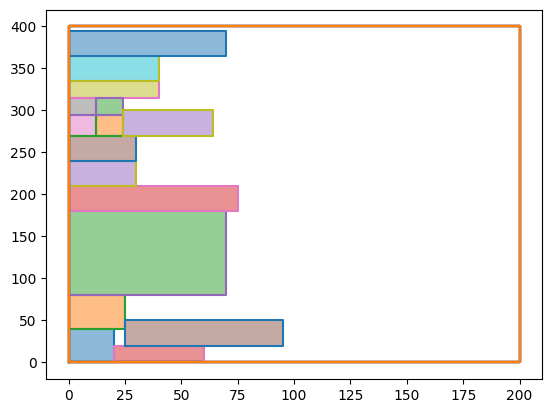

In [125]:
house_polygons = []

# Iterate over houses and create polygons
for i in range(len(houses)):
    # Extract coordinates from the optimized solution
    is_placed = solver.Value(placed_vars[i])
    if is_placed:
      x1_val = solver.Value(x1_coords[i])
      x2_val = solver.Value(x2_coords[i])
      y1_val = solver.Value(y1_coords[i])
      y2_val = solver.Value(y2_coords[i])

      # Create a Polygon object for the house
      house_polygon = Polygon([(x1_val, y1_val), (x2_val, y1_val), (x2_val, y2_val), (x1_val, y2_val), (x1_val, y1_val)])

      # Append the polygon to the list
      house_polygons.append(house_polygon)

# Now, house_polygons contains a Polygon object for each house
# You can iterate over house_polygons to access and visualize each polygon
for house_polygon in house_polygons:
    # Plot the polygon
    x, y = house_polygon.exterior.xy
    plt.plot(x, y)
    plt.plot(*site_simplified.exterior.xy)
    plt.fill(x, y, alpha=0.5)  # Fill the polygon

In [126]:
len(house_polygons)

16

### 🧩 Task II - adding the roads

Our houses are placed in a dense grid. Add roads, bike lanes and walkways as constraints to our model

In [ ]:
# your code here